# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 8</span>


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

### Exercise 08.2

One of the aims of lesson 8 is to write a code to solve an analytically unsolvable problem: I had to variationally optimize the ground state of a single quantum particle in a one dimensional space confined by the potential:

$$
V(x) = x^4 - \frac{5}{2}x^2
$$

In particular I wrote a Variational Monte Carlo code to sample the trial wave function (approximate model for the ground state wave function):

$$
\Psi_T^{\sigma,\mu}(x) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}}+
                               e^{-\frac{(x+\mu)^2}{2\sigma^2}}
$$

The goal is to find the wave function parameters $\sigma$ and $\mu$ which minimize $\langle {\hat H} \rangle_T$:

$$
\langle {\hat H} \rangle_T = \frac{\langle \Psi_T^{\sigma,\mu}| {\hat H} | \Psi_T^{\sigma,\mu} \rangle}
{\langle \Psi_T^{\sigma,\mu} | \Psi_T^{\sigma,\mu} \rangle} \ge E_0 =
\frac{\langle \Psi_0| {\hat H} | \Psi_0 \rangle}
{\langle \Psi_0 | \Psi_0 \rangle}
$$

#### Simulated Annealing routine

In order to do this I created and performed a Simulated Annealing routine called `OptimizeParameters()` (it can be found in the file `../LSN_Exercise_082.cpp`).
This routine is composed by two nested cycles:
- an outer one over a certain range of fictious temperatures $T$;
- an inner one over a certain number of steps in which I sample new values of $\mu$ and $\sigma$.

So for each step of the inner cycle, I compute the average of the hamiltonian with current values of $\mu$ and $\sigma$, then I perform a uniform step to get new values of the parameters and again compute the average of the hamiltonian. 
I then accept the new values of the parameters with probability $p = exp(\frac{-1}{T}[< \hat H(\mu_{new};\sigma_{new}) > - < \hat H(\mu;\sigma) >])$.

```cpp
    x0 = 0
    temperature = starting_temperature
    while ( temperature > delta_temperature )
        for( 0 < istep < noptsteps )
            
            old_hamiltonian_average = GetHamiltonianAverage(x0,mu,sigma,n)
            
            new_mu = mu + delta_opt*(rand(0,1) - 0.5)
            new_sigma = sigma + delta_opt*(rand(0,1) - 0.5)
            
            new_hamiltonian_average = GetHamiltonianAverage(x0,new_mu,new_sigma,n)
            
            p = exp (-1/temperature * (new_hamiltonian_average - old_hamiltonian_average) )
            if (rand(0,1) <= p)
                mu = new_mu
                sigma = new_sigma
    
        temperature = temperature - delta_temperature
```

Once the procedure is finished, I select $\mu$ and $\sigma$ values for which I observe the minimum value of the average hamiltonian $< \hat H(\mu;\sigma) >$. 
All the parameters values sampled during this procedure is shown below. 
Are also printed the values of $\mu$ and $\sigma$ for which I get the minimum value of $< \hat H(\mu;\sigma) >$.

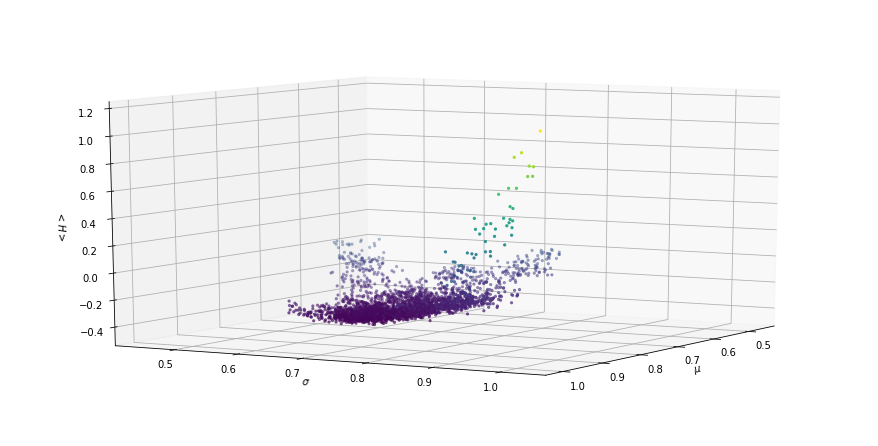

<H> minimized for mu = 0.791754 , sigma = 0.637379


In [40]:
mu, sigma, H = np.loadtxt("../results/sampled_mu_sigma.dat", usecols=(0,1,2), unpack = True)

fig = plt.figure(figsize = (12, 6))
ax = Axes3D(fig)
ax.scatter(mu, sigma, H, c=H, marker='.')
ax.set_xlabel('$\mu$')
ax.set_ylabel('$\sigma$')
ax.set_zlabel('$<H>$')
ax.view_init(10, 30)

plt.show()

print("<H> minimized for mu =", mu[np.argsort(H)[0]], ", sigma =", sigma[np.argsort(H)[0]])

Using this routine, one has to pay attention to not start from a too high starting temperature ($T=0.1$ in my case) in order to converge to the desired value of $< \hat H(\mu;\sigma) >$ when the temperature in decreased.

#### Results

With this optimized values of the parameters, I then produced a picture of the estimation of $\langle {\hat H} \rangle_T$ and its statistical uncertainty as a function of the number of blocks, calculated with parameters found above.

I also plotted the histogram with the sampled configurations to obtain the sampled wave function $|\Psi_T(x)|^2$, and I compared it with the analytic curve and the numerical solution provided.

Results are shown below.

In [29]:
def Vpot(x):
    return (x**2 - 2.5)*x**2
    #return 0.5*x**2
    
def PDF(x, mu, sigma):
    wf=np.exp(-(x-mu)**2/(2.*sigma**2))+np.exp(-(x+mu)**2/(2.*sigma**2))
    return wf*wf

hbar = 1
m = 1
a = 6
N = 1000 # number of iterations

# Step sizes
x = np.linspace(-a/2, a/2, N)
dx = x[1] - x[0] # the step size
V = Vpot(x)

# The central differences method: f" = (f_1 - 2*f_0 + f_-1)/dx^2

CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
# np.diag(np.array,k) construct a "diagonal" matrix using the np.array
# The default is k=0. Use k>0 for diagonals above the main diagonal, 
# and k<0 for diagonals below the main diagonal

# Hamiltonian matrix
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)

# Compute eigenvectors and their eigenvalues
E,psi = np.linalg.eigh(H)

# Take the transpose & normalize
psi = np.transpose(psi)
psi = psi/np.sqrt(dx)

print("Ground state energy: ", E[0])

Ground state energy:  -0.4604584507991177


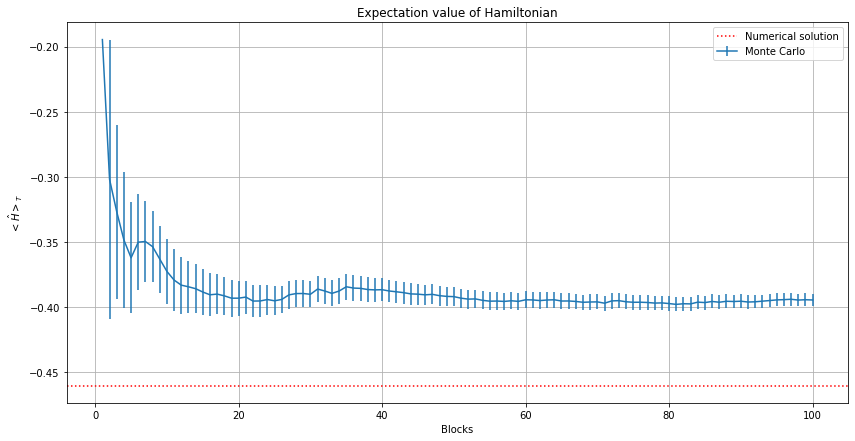

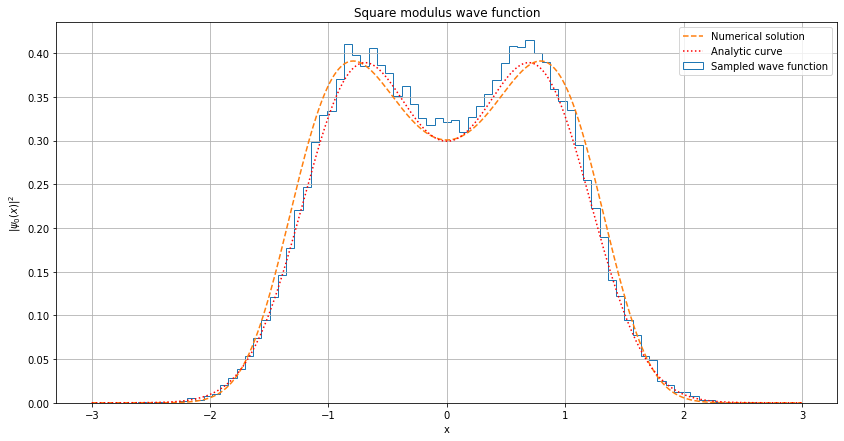

In [36]:
plt.figure(1, figsize = (14, 7))

x_H, y_H, yerr_H = np.loadtxt("../results/h_ave.dat", unpack = True)
plt.title("Expectation value of Hamiltonian")
plt.xlabel('Blocks')
plt.ylabel('$< \hat H >_T$')
plt.axhline(y=E[0], color='r', linestyle="dotted", label = "Numerical solution")
plt.errorbar(x_H, y_H, yerr_H, label = "Monte Carlo")
plt.grid(True)
plt.legend()

plt.figure(2, figsize = (14, 7))

x_pos = np.loadtxt("../results/x_pos.dat")

scale = 0.35
#plt.plot(data_x, data_y, label="Sampled wave function")
plt.hist(x_pos, 80, density=True, histtype='step', label="Sampled wave function")
plt.plot(x,(psi[0])**2, label="Numerical solution", linestyle='dashed')
plt.plot(x, scale*PDF(x, 0.791754, 0.637379), label="Analytic curve", color='r', linestyle="dotted")
plt.title("Square modulus wave function")
plt.xlabel("x")
plt.ylabel(r"$|\psi_0(x)|^2$")
plt.grid(True)
plt.legend()

plt.show()

### Exercise 08.3

I then used the provided `PIMC/PIGS` code to study the same 1D quantum system described above.
I reported the results obtained using PIGS algorithm ($T=0$) in two different scenarios, starting from two different trial wave functions:

- $\Psi_T(x)=1$ (constant trial wave function)
- $\Psi_T(x) = \Psi_T^{\sigma,\mu}(x)$ (with variational parameters $\mu$ and $\sigma$ that I found in previous exercise)

Parameters used for the simulation are those reported in file **input.pigs**, except for the parameter *imaginaryTimePropagation* (specified below).

Below I reported the graphs of such results compared with those obtained with my Monte Carlo code and with the numerical solution.